<a href="https://colab.research.google.com/github/edeery3/Applied-Data-Science-1/blob/main/GSK_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preprocessing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [6]:
gsk = pd.read_excel('/Stockdataset.xlsx', engine = 'openpyxl', sheet_name = 'GSK')

In [7]:
def convert_volume(val):
    val = str(val).strip().upper()
    if 'M' in val:
        return float(val.replace('M', '')) * 1000000
    elif 'K' in val:
        return float(val.replace('K', '')) * 1000
    elif val.replace('.', '', 1).isdigit():
        return float(val)
    else:
        return 0

In [8]:
gsk.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,1
Change %,0


In [9]:
gsk['Vol.'] = gsk['Vol.'].apply(convert_volume)

In [11]:
gsk.drop('Date', axis = 1).describe()

,Price,Open,High,Low,Vol.,Change %
count,2527.000000,2527.000000,2527.000000,2527.000000,2.527000e+03,2527.000000
mean,1516.391286,1516.399632,1530.648627,1502.953221,7.011167e+06,0.000068
std,137.163824,136.753475,137.508894,135.948140,3.590257e+06,0.013074
min,1202.780000,1213.080000,1227.620000,1202.780000,0.000000e+00,-0.100600
25%,1404.840000,1403.995000,1418.580000,1389.955000,4.820000e+06,-0.006750
50%,1510.550000,1511.800000,1525.400000,1496.510000,6.130000e+06,0.000100
75%,1625.495000,1624.380000,1638.575000,1611.070000,8.020000e+06,0.007100
max,1864.580000,1864.370000,1875.690000,1846.600000,4.366000e+07,0.076100


In [12]:
gsk['Date'] = pd.to_datetime(gsk['Date'])
gsk.set_index('Date', inplace=True)
gsk.sort_index(inplace=True)


In [13]:
gsk['SMA_20'] = gsk['Price'].rolling(window=20).mean()
gsk['Volatility_20'] = gsk['Price'].rolling(window=20).std()

In [21]:
train_start = '2015-04-01'
train_end = '2023-04-01'

# Use index-based slicing
train_gsk = gsk[train_start:train_end]
test_gsk = gsk[train_end:]

print(f"Train size: {len(train_close)}, Test size: {len(test_close)}")

Train size: 2022, Test size: 505


Exploratory Data Analysis Plots

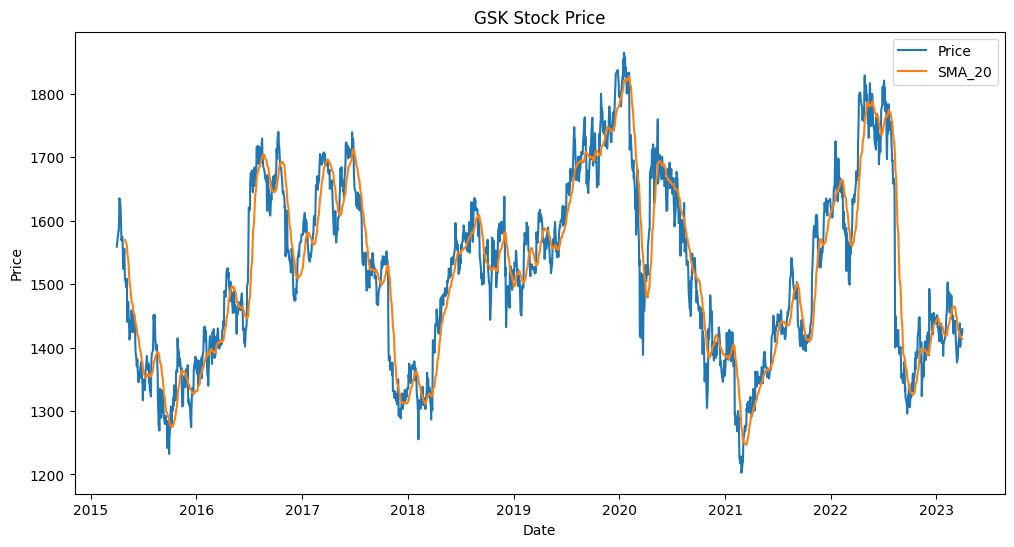

In [22]:
plt.figure(figsize = (12,6))
plt.plot(train_gsk['Price'])
plt.plot(train_gsk['SMA_20'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Stock Price')
plt.legend(['Price', 'SMA_20'])
plt.show()

In [23]:
fig = go.Figure(data=[go.Candlestick(
    open=train_gsk['Open'],
    high=train_gsk['High'],
    low=train_gsk['Low'],
    close=train_gsk['Price'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])

fig.update_layout(title='Candlestick Chart Example', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [24]:
gsk_mean = np.mean(train_gsk['Price'])

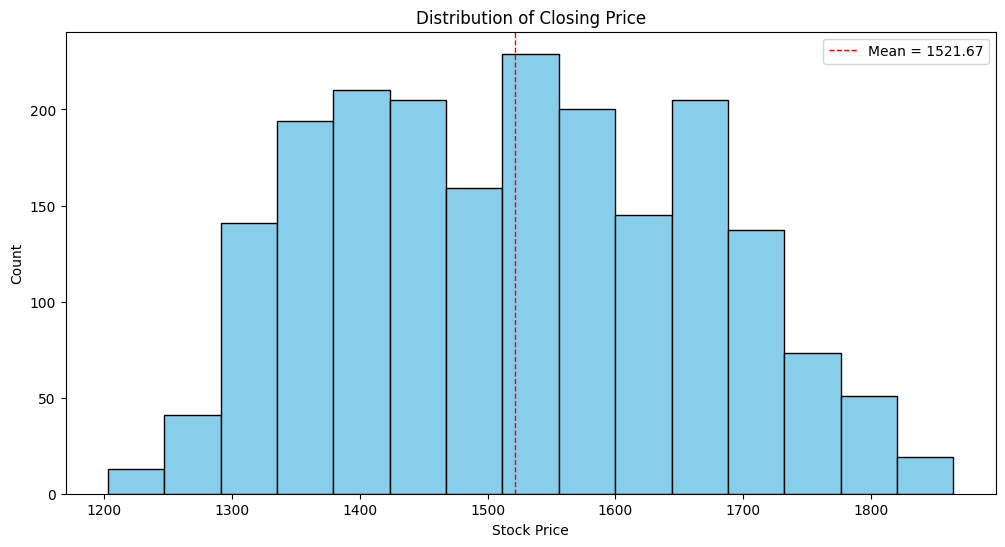

In [25]:
plt.figure(figsize = (12,6))
plt.hist(train_gsk['Price'], bins = 15, lw = 2, edgecolor = 'black', color = 'skyblue')
plt.xlabel('Stock Price')
plt.ylabel('Count')
plt.title('Distribution of Closing Price')
plt.axvline(gsk_mean, color='red', linestyle='--', linewidth=1, label=f'Mean = {gsk_mean:.2f}')
plt.legend()

ARIMA

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
import statsmodels.api as sm

In [27]:
train_close = train_gsk['Price']
test_close = test_gsk['Price']

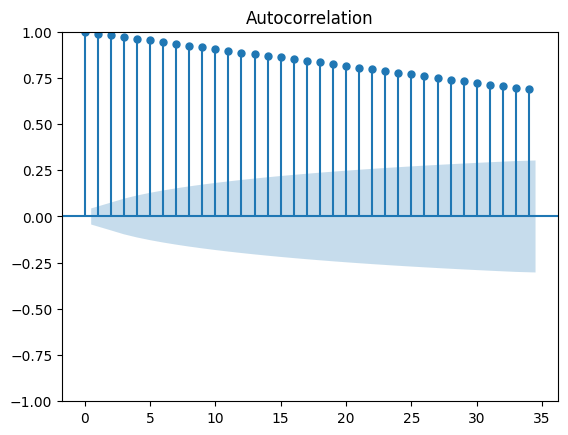

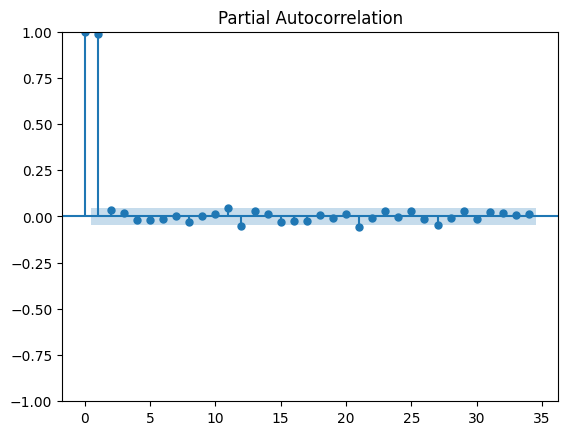

In [28]:
plot_acf(train_close)
plot_pacf(train_close)
plt.show()

In [29]:
result = adfuller(train_close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.021990483292543
p-value: 0.03289117694360855


In [30]:
train_close = train_close.asfreq(pd.infer_freq(train_close.index))
train_close = train_close.interpolate(method='linear')

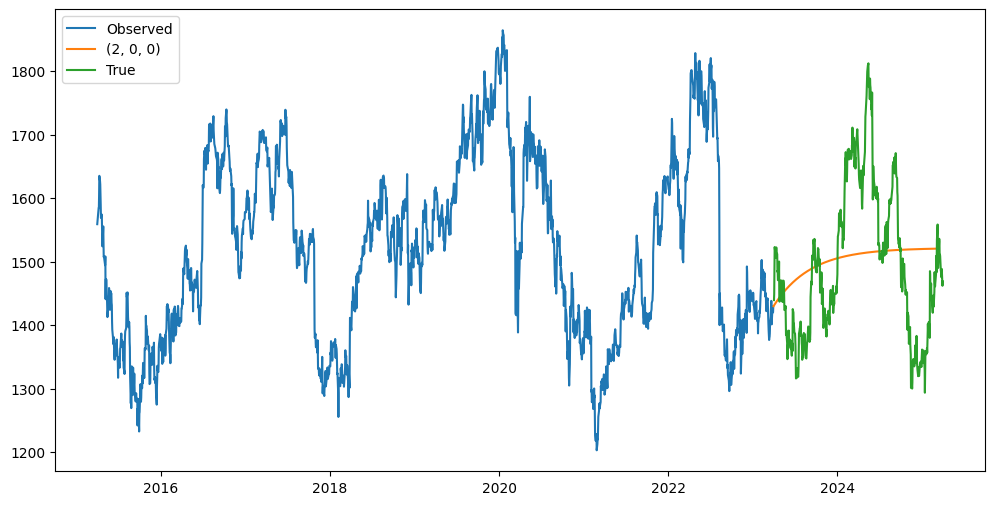

In [31]:
# ARIMA fit
model = ARIMA(train_close, order=(2, 0, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=700)

# Plot
plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.legend()
plt.show()

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np

results_list = []

for p in range(6):
    for d in range(3):
        for q in range(6):
                model = ARIMA(train_close, order=(p, d, q))
                fitted = model.fit()

                # Residuals and in-sample predictions
                resid = fitted.resid
                insample_pred = fitted.fittedvalues
                insample_actual = train_close[-len(insample_pred):]
                rmse_insample = np.sqrt(mean_squared_error(insample_actual, insample_pred))

                # Forecast on test set
                forecast = fitted.forecast(steps=len(test_close))
                rmse_outsample = np.sqrt(mean_squared_error(test_close, forecast))

                # AIC and BIC
                aic = fitted.aic
                bic = fitted.bic

                # Residual diagnostics
                if len(resid) > 10:
                    ljung_box_p = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
                    res_skew = skew(resid)
                    res_kurt = kurtosis(resid)
                else:
                    ljung_box_p = np.nan
                    res_skew = np.nan
                    res_kurt = np.nan

                # Store results
                results_list.append({
                    'order': (p, d, q),
                    'AIC': aic,
                    'BIC': bic,
                    'RMSE_in': rmse_insample,
                    'RMSE_out': rmse_outsample,
                    'LjungBox_p': ljung_box_p,
                    'Skewness': res_skew,
                    'Kurtosis': res_kurt
                })


# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Sort by out-of-sample RMSE
results_df = results_df.sort_values(by='RMSE_out')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likel

In [40]:
results_df = results_df.sort_values(by='RMSE_out').reset_index(drop=True)

results_df.head()

,order,AIC,BIC,RMSE_in,RMSE_out,LjungBox_p,Skewness,Kurtosis
0,"(3, 0, 5)",24271.586850,24331.387086,15.350466,113.837889,0.968802,-0.537686,9.963490
1,"(3, 0, 4)",24269.547114,24323.367327,15.350282,113.838874,0.985132,-0.534753,9.958958
2,"(2, 0, 5)",24269.952238,24323.772451,15.351457,113.861594,0.945155,-0.540153,9.977434
3,"(4, 0, 5)",24272.577180,24338.357440,15.347648,113.882310,0.980208,-0.524653,9.980407
4,"(2, 0, 4)",24268.294208,24316.134397,15.352285,113.960666,0.931486,-0.545489,9.996153


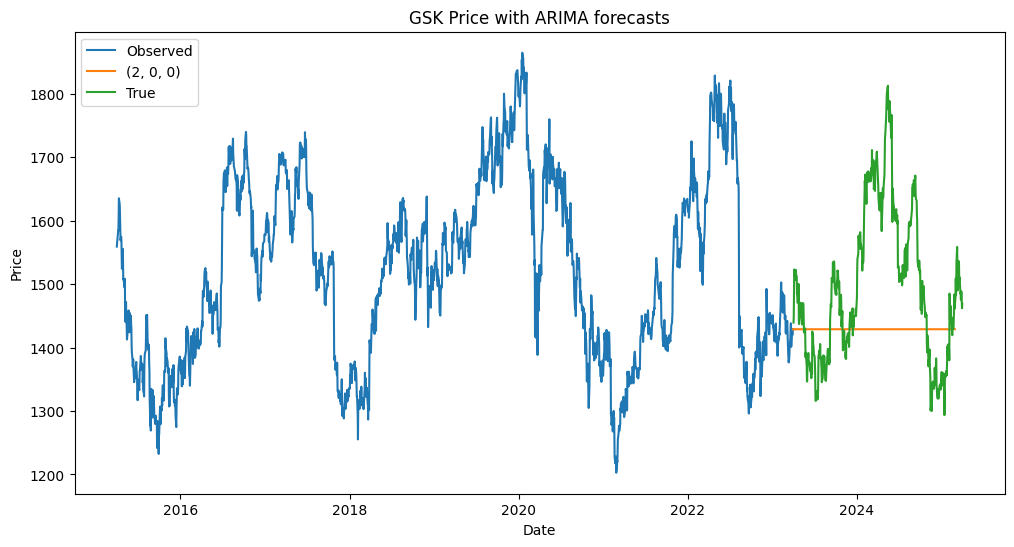

In [37]:

model = ARIMA(train_close, order=(2, 1, 2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



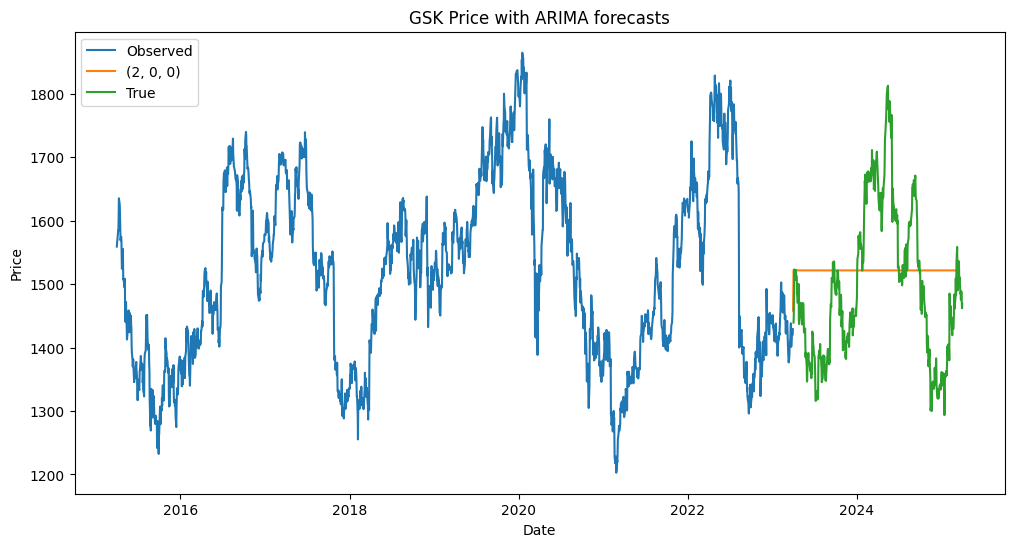

In [38]:
model = ARIMA(train_close, order=(0, 0, 2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

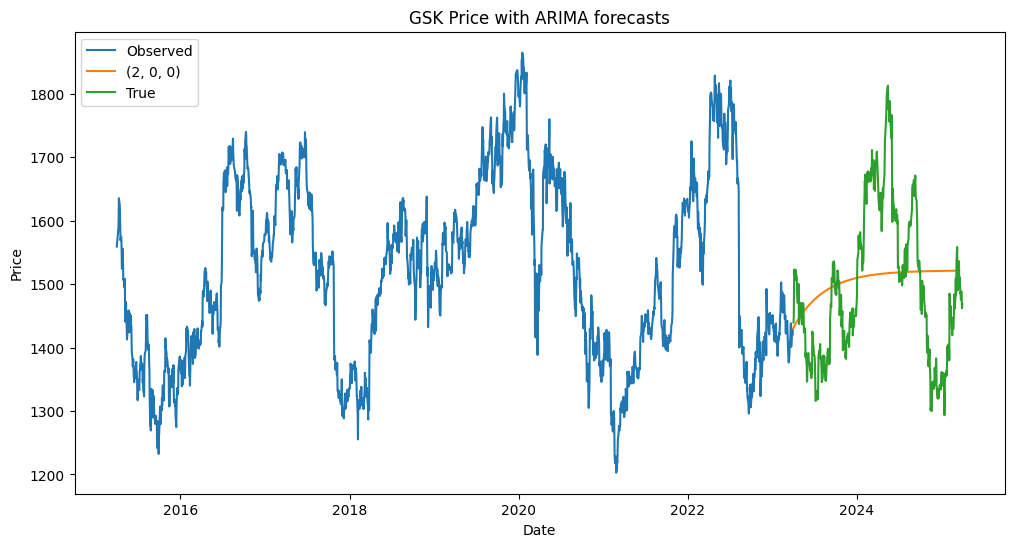

In [41]:
model = ARIMA(train_close, order=(3, 0, 5))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

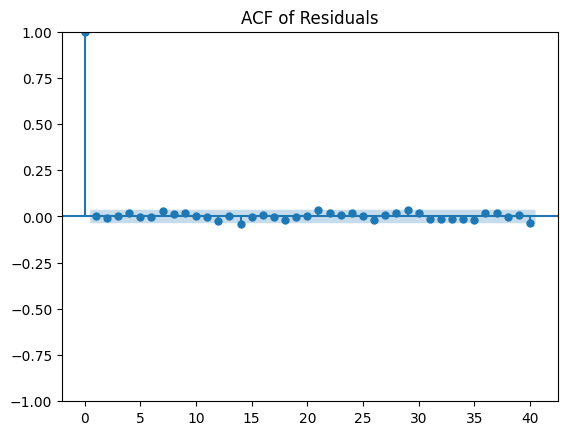

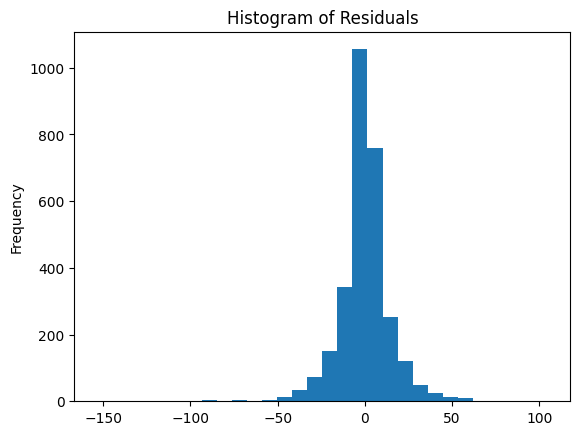

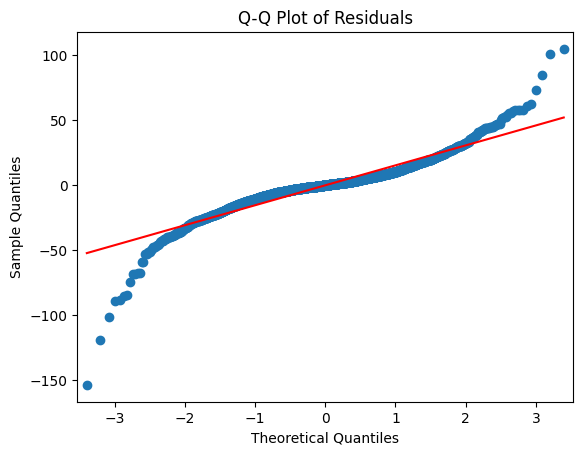

In [44]:
model = ARIMA(train_close, order=(2, 0, 0))
model_fit = model.fit()


residuals = model_fit.resid

# ACF plot
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Histogram
residuals.plot(kind='hist', bins=30, title='Histogram of Residuals')
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()